Imports

In [23]:
import gym
import numpy as np
import torch

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 10)

Our functions

In [24]:
from Train_policy_func import Policy, load_policy
from Plot_Functions import plot_suboptimality, plot_trajectory_performance, plot_Scores, plot_suboptimality_three_policies, plot_scores_RLHF, plot_avg_loss_curves,plot_avg_reward_curves
from OPPO import baseline_CartPole_v0_Fla, OPPO_update, set_seed
from PPO import evaluate_policy
from pairs_generator import sample_preference_pairs
from DPO import DPO_training



beta by default 0.5


Creating policies and changing seeds:

In [25]:
# env 1: CartPole-v0
env_name='CartPole-v0'
env = gym.make(env_name)
obs_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

baseline = baseline_CartPole_v0_Fla
target_score = 190 # for CartPole-v0

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ── Hyperparams for OPPO ──
lr_oppo                 = 0.003
n_episodes              = 1200 # keep same “number of iterations” for fair comparison
max_t                   = 500  # cap on steps per episode
print_every             = 50   # print every x episodes and avg also the score for every x episodes
gamma                   = 0.99


# ── Options for the Run ──
load_policies   = True
evaluate_pi_ref = False
plot_scores     = False
n_eval          = 100

Policy_list     = []
seeds_list      = [35, 42, 100]
# seeds_list      = [35]

for seed in seeds_list:
    set_seed(seed, env)

    if load_policies:
        print(fr"Loading pi_1 and pi_2 with {seed=}")
        pi_1 = load_policy(f"./Policies/pi1_ref_{env_name}_seed_{seed}.pth", obs_dim, action_dim, device)
        pi_2 = load_policy(f"./Policies/pi2_ref_{env_name}_seed_{seed}.pth", obs_dim, action_dim, device)

    else:
        print(f"Training pi_1 and pi_2 with seed {seed}")

        pi_1 = Policy(state_size=obs_dim, action_size=action_dim).to(device)
        opt1 = torch.optim.Adam(pi_1.parameters(), lr=lr_oppo)


        scores_oppo = OPPO_update(
            policy          = pi_1,
            optimizer       = opt1,
            env             = env,
            baseline        = baseline,
            n_episodes      = n_episodes,
            max_t           = max_t,
            gamma           = gamma,      # you can reuse your PPO γ
            print_every     = print_every,
            early_stop      = False,
            seed            = seed,
            target_score    = target_score,
            env_name        = env_name,
            display_every   = False
        )


        pi_2 = load_policy(f"./Policies/pi2_ref_{env_name}_seed_{seed}.pth", obs_dim, action_dim, device)
    Policy_list.append([pi_1, pi_2])
    # print("------------------------------------------------------")

print("=================================")


Loading pi_1 and pi_2 with seed=35
Loading pi_1 and pi_2 with seed=42
Loading pi_1 and pi_2 with seed=100


C:\Users\turin\AppData\Roaming\Python\Python311\site-packages\gym\envs\registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
C:\Users\turin\AppData\Roaming\Python\Python311\site-packages\gym\core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
C:\Users\turin\AppData\Roaming\Python\Python311\site-packages\gym\wrappers\step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
c:\Users\turin\OneDrive\EPFL\Master\MA2\RL\RLHF\Git RLHF\RL-RLHF\Train_policy_func.py:48: FutureWarning: You are using `torch.load` with 

## Evaluations of the reference policies pi_1 and pi_2

In [26]:
if evaluate_pi_ref:# ── Evaluate the policies ──
  print("Evaluating pi_1 and pi_2 for all seeds: \n")
  for seed, (pi_1, pi_2) in zip(seeds_list, Policy_list):
      
      print(f"Evaluating pi_1 and pi_2 with {seed=} over {n_eval} episodes")
      # Evaluate the policies
      seed_eval = seed+32
      _, pi1_rewards = evaluate_policy(pi_1, env, n_episodes=n_eval, seed=seed_eval)
      _, pi2_rewards = evaluate_policy(pi_2, env, n_episodes=n_eval, seed=seed_eval)
      print(f"Evaluations over {n_eval} episodes done for both policies, using the seed {seed}")
      print(f"pi_1({seed}) \t mean reward: \t {np.mean(pi1_rewards):.2f} ± {np.std(pi1_rewards):.2f}")
      print(f"pi_2({seed}) \t mean reward: \t {np.mean(pi2_rewards):.2f} ± {np.std(pi2_rewards):.2f}")

      if plot_scores:
          plot_Scores(
              pi1_rewards,
              pi2_rewards,
          )
      print("------------------------------------------------------")


  print("=================================")

## We now implement DPO to train a new policy with the help of pi_1|2

Choose freely n_pairs to try different size for the preference dataset

In [27]:
# ── Hyperparams for DPO ──
n_pairs         = 200
lr_DPO          = 0.01
beta            = 0.5
print_dpo        = 30
n_epochs_dpo     = 300

load_pi_dpo     = False
load_from_pi2   = False
evaluate_pi_DPO = False
plot_scores     = False
plot_learning_curves = True
pair_list          = [10, 50, 200, 1000] # number of preference pairs to collect
# pair_list          = [10] # number of preference pairs to collect

Policy_DPO_list = []
Loss_history_list = []
reward_train_list=[]
for n_pair in pair_list:
    print(f"=============== using {n_pair=} ==================")
    # Pol_pair_rlhf     = []
    Pol_pair_DPO  = []
    loss_hist_1seed = []
    reward_train_1seed=[]

    for seed, (pi_1, pi_2) in zip(seeds_list, Policy_list):
        if load_pi_dpo:
            print(f"Loading pi_DPO with {seed=} for the environment {env_name}")
            policy_DPO = load_policy(f"./Policies/pi_DPO_{env_name}_seed_{seed}_beta{beta}_Npairs_{n_pairs}.pth", obs_dim, action_dim, device)
        else:
            print(f"Beginning DPO with {seed=}")
            prefs = sample_preference_pairs(pi_1, pi_2, env, K=n_pairs) # Need to define K elsewhere as hyperparameter
            print(f"Collected {len(prefs)} preference pairs.")

            policy_DPO=Policy(state_size=obs_dim, action_size=env.action_space.n).to(device)
            if load_from_pi2:
                policy_DPO.load_state_dict(torch.load(f"./Policies/pi2_ref_{env_name}_seed_{seed}.pth"))
            opt_DPO    = torch.optim.Adam(policy_DPO.parameters(), lr=lr_DPO)


            loss_hist, rewards_across_training = DPO_training(policy_DPO, pi_1, prefs, beta, env ,opt_DPO, nb_epochs=n_epochs_dpo) #, print_every=print_dpo
            torch.save(policy_DPO.state_dict(), f"./Policies/pi_DPO_{env_name}_seed_{seed}_beta{beta}_Npairs_{n_pairs}.pth")
            print(f"Saved final policy as ./Policies/pi_DPO_{env_name}_seed_{seed}_beta{beta}_Npairs_{n_pairs}.pth")
        Pol_pair_DPO.append(policy_DPO)
        loss_hist_1seed.append(loss_hist)
        reward_train_1seed.append(rewards_across_training)
    # Policy_rlhf_list.append(Pol_pair_rlhf)
    Policy_DPO_list.append(Pol_pair_DPO)
    Loss_history_list.append(loss_hist_1seed)
    reward_train_list.append(reward_train_1seed)
torch.save(Loss_history_list, f"./Policies/LossCurve_DPO_{env_name}_beta{beta}_Lastpair_{n_pair}.pth")
torch.save(reward_train_list, f"./Policies/rewardTraining_DPO_{env_name}_Lastpair_{n_pair}.pth")
print("=================================")
    
if evaluate_pi_DPO:
    print(f"Evaluating pi_DPO with {seed=}, {beta=} over {n_eval} episodes")
    # Evaluate the policies
    seed_eval = seed+32
    _, pi1_rewards     = evaluate_policy(pi_1,       env, n_episodes=n_eval, seed=seed_eval)
    _, pi_dpo_rewards   = evaluate_policy(policy_DPO, env, n_episodes=n_eval, seed=seed_eval)
    _, pi2_rewards      = evaluate_policy(pi_2,       env, n_episodes=n_eval, seed=seed_eval)
    print(f"Evaluations over {n_eval} episodes using the evalutation seed {seed_eval}")
    print(f"pi_1({seed})    \t mean reward: \t {np.mean(pi1_rewards):.2f} ± {np.std(pi1_rewards):.2f}")
    print(f"pi_INIT({seed}) \t mean reward: \t {np.mean(pi2_rewards):.2f} ± {np.std(pi2_rewards):.2f}")
    print(f"pi_DPO({seed})  \t mean reward: \t {np.mean(pi_dpo_rewards):.2f} ± {np.std(pi_dpo_rewards):.2f}")

    if plot_scores:
        plot_Scores(
            pi1_rewards,
            pi2_rewards,
        )

print("=================================")


C:\Users\turin\AppData\Roaming\Python\Python311\site-packages\gym\utils\passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


=============== using n_pair=10 ==================
Beginning DPO with seed=35
Collected 200 preference pairs.
Epoch 0: DPO Loss = 1.418632e+01
Epoch 10: DPO Loss = 9.215289e+00
Epoch 20: DPO Loss = 6.740448e+00
Epoch 30: DPO Loss = 3.791706e+00
Epoch 40: DPO Loss = 8.252640e-01
Epoch 50: DPO Loss = 3.905884e-01
Epoch 60: DPO Loss = 3.465023e-01
Epoch 70: DPO Loss = 2.748032e-01
Epoch 80: DPO Loss = 2.104938e-01
Epoch 90: DPO Loss = 1.761355e-01
Epoch 100: DPO Loss = 1.620998e-01
Epoch 110: DPO Loss = 1.556709e-01
Epoch 120: DPO Loss = 1.500747e-01
Epoch 130: DPO Loss = 1.453602e-01
Epoch 140: DPO Loss = 1.414673e-01
Epoch 150: DPO Loss = 1.380909e-01
Epoch 160: DPO Loss = 1.351047e-01
Epoch 170: DPO Loss = 1.324444e-01
Epoch 180: DPO Loss = 1.299507e-01
Epoch 190: DPO Loss = 1.276358e-01
Epoch 200: DPO Loss = 1.253704e-01
Epoch 210: DPO Loss = 1.230597e-01
Epoch 220: DPO Loss = 1.209903e-01
Epoch 230: DPO Loss = 1.190601e-01
Epoch 240: DPO Loss = 1.173339e-01
Epoch 250: DPO Loss = 1.15

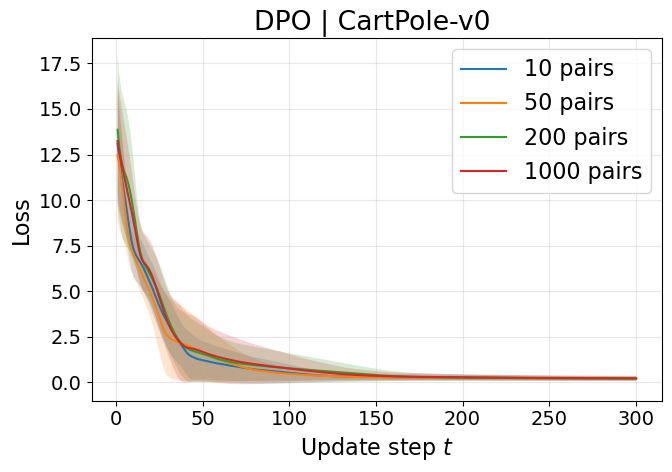

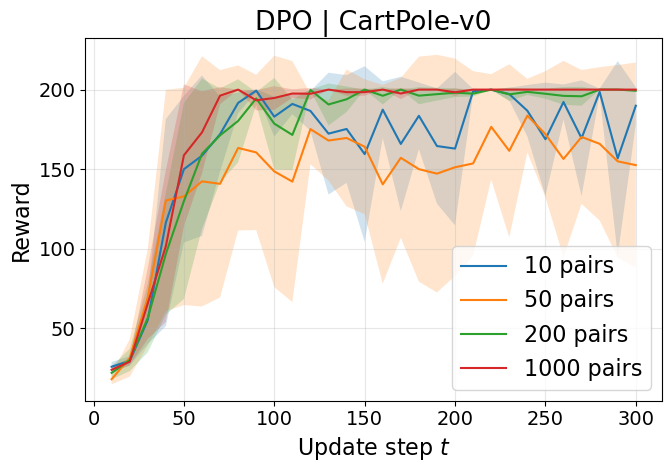

In [32]:
# ── Plotting the loss curves ──
plot_avg_loss_curves(
    loss_hist_list=Loss_history_list, 
    pair_list=pair_list, 
    algo="DPO",
    legend=True,
    save=True,
    env_name=env_name,
)
plot_avg_reward_curves(reward_train_list,pair_list,legend=True, save=True, env_name=env_name)

Evaluating DPO for all seeds and dataset size over 100 Runs 

=============== using n_pair=10 ==================
Evaluations over 100 episodes done for the 3 policies, averaged over the 3 seeds for n_pair=10
pi_1(10)        	 mean reward: 	 185.31 ± 17.49
pi_2(10)        	 mean reward: 	 113.52 ± 28.82
pi_DPO(10) 	 mean reward: 	 188.75 ± 19.03
------------------------------------------------------
=============== using n_pair=50 ==================
Evaluations over 100 episodes done for the 3 policies, averaged over the 3 seeds for n_pair=50
pi_1(50)        	 mean reward: 	 185.69 ± 16.54
pi_2(50)        	 mean reward: 	 113.89 ± 29.48
pi_DPO(50) 	 mean reward: 	 162.54 ± 23.76
------------------------------------------------------
=============== using n_pair=200 ==================
Evaluations over 100 episodes done for the 3 policies, averaged over the 3 seeds for n_pair=200
pi_1(200)        	 mean reward: 	 186.38 ± 17.68
pi_2(200)        	 mean reward: 	 112.54 ± 26.28
pi_DPO(200) 

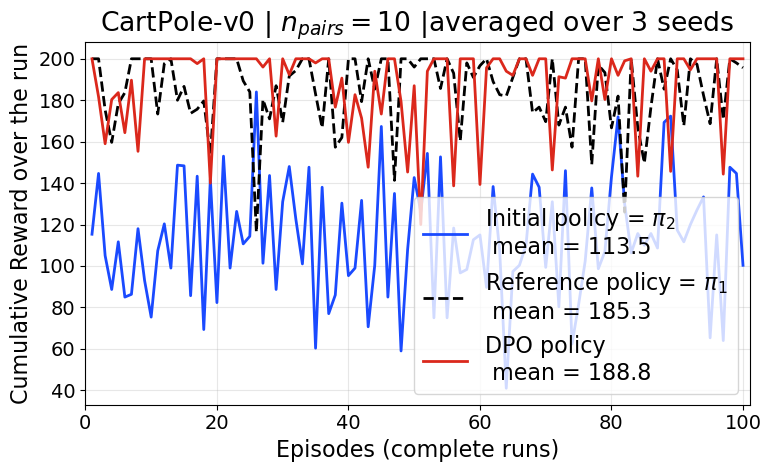

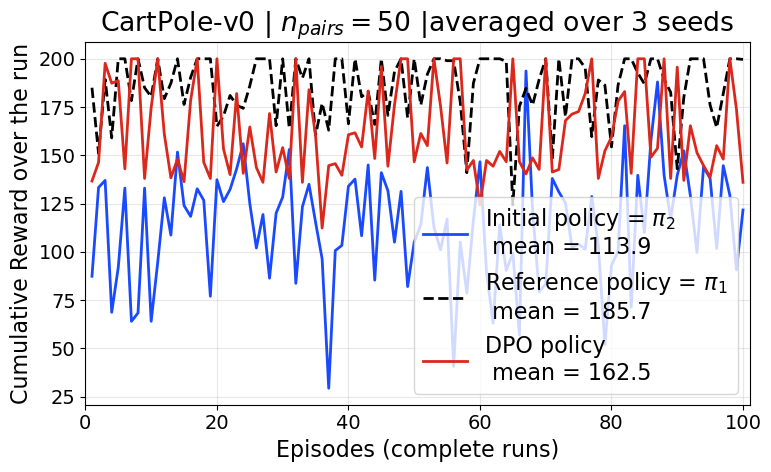

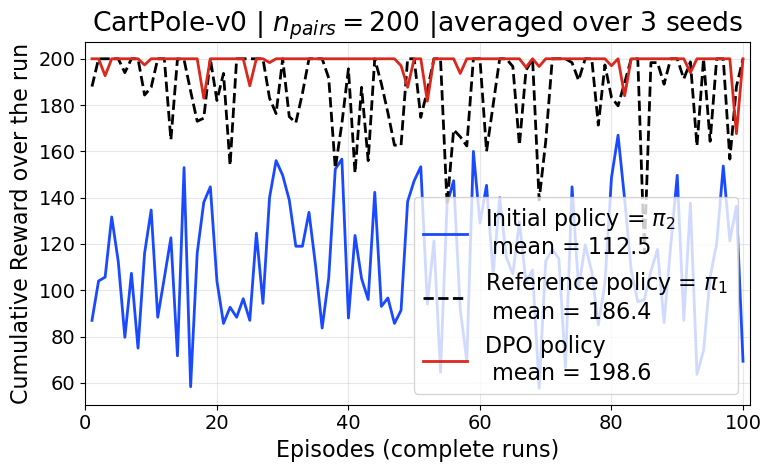

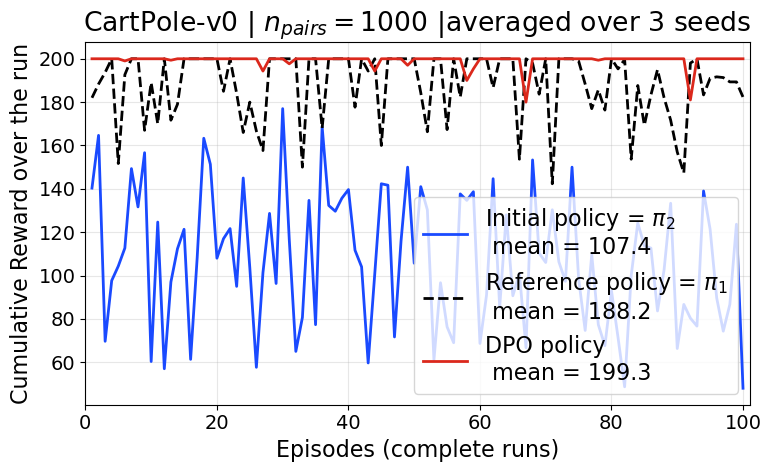

In [30]:

print(f"Evaluating DPO for all seeds and dataset size over {n_eval} Runs \n")
compare_policies     = True
plot_scores          = True

for i, n_pair in enumerate(pair_list):
    print(f"=============== using {n_pair=} ==================")    
    R_ref = 0
    R_init = 0
    R_DPO = 0
    
    for seed, (pi_1, pi_2), pi_DPO in zip(seeds_list, Policy_list, Policy_DPO_list[i]):
        seed_eval = seed+32
        _, pi1_rewards          = evaluate_policy(pi_1,     env, n_episodes=n_eval, seed=seed_eval)
        _, pi2_rewards          = evaluate_policy(pi_2,     env, n_episodes=n_eval, seed=seed_eval)
        _, pi_DPO_rewards  = evaluate_policy(pi_DPO, env, n_episodes=n_eval, seed=seed_eval)
        # _, pi_rlhf_rewards      = evaluate_policy(pi_rlhf,  env, n_episodes=n_eval, seed=seed_eval)

        # print(pi1_rewards, np.mean(pi1_rewards), np.std(pi1_rewards))
        R_ref       += np.array(pi1_rewards)/len(seeds_list)
        R_init      += np.array(pi2_rewards)/len(seeds_list)
        R_DPO  += np.array(pi_DPO_rewards)/len(seeds_list)
        
    if compare_policies:
        print(f"Evaluations over {n_eval} episodes done for the 3 policies, averaged over the 3 seeds for {n_pair=}")
        print(f"pi_1({n_pair})        \t mean reward: \t {np.mean(R_ref):.2f} ± {np.std(R_ref):.2f}")
        print(f"pi_2({n_pair})        \t mean reward: \t {np.mean(R_init):.2f} ± {np.std(R_init):.2f}")
        # print(f"pi_RLHF({seed})     \t mean reward: \t {np.mean(pi_rlhf_rewards):.2f} ± {np.std(pi_rlhf_rewards):.2f}")
        print(f"pi_DPO({n_pair}) \t mean reward: \t {np.mean(R_DPO):.2f} ± {np.std(R_DPO):.2f}")
    if plot_scores:
        plot_scores_RLHF(R_init, R_ref, R_DPO, algo="DPO", save=True, n_pair=n_pair, env_name=env_name)

        print("------------------------------------------------------")



In [ ]:
# pi1_rewards_mean=np.zeros(n_eval)
# pi2_rewards_mean=np.zeros(n_eval)
# pi_dpo_rewards_mean=np.zeros(n_eval)
# for seed, (pi_1, pi_2), pi_dpo in zip(seeds_list, Policy_list, Policy_DPO_list):
#   print(f"Evaluating pi_1, pi_2 and pi_DPO with {seed=}, {beta=} over {n_eval} episodes")
#   # Evaluate the policies
#   seed_eval = seed+32
#   _, pi1_rewards     = evaluate_policy(pi_1,        env, n_episodes=n_eval, seed=seed_eval)
#   _, pi_dpo_rewards   = evaluate_policy(pi_dpo,     env, n_episodes=n_eval, seed=seed_eval)
#   _, pi2_rewards      = evaluate_policy(pi_2,       env, n_episodes=n_eval, seed=seed_eval)
#   print(f"Evaluations over {n_eval} episodes using the evalutation seed {seed_eval}")
#   print(f"pi_1({seed})    \t mean reward: \t {np.mean(pi1_rewards):.2f} ± {np.std(pi1_rewards):.2f}")
#   print(f"pi_INIT({seed}) \t mean reward: \t {np.mean(pi2_rewards):.2f} ± {np.std(pi2_rewards):.2f}")
#   print(f"pi_DPO({seed})  \t mean reward: \t {np.mean(pi_dpo_rewards):.2f} ± {np.std(pi_dpo_rewards):.2f}")

#   pi1_rewards_mean+=pi1_rewards
#   pi2_rewards_mean+=pi2_rewards
#   pi_dpo_rewards_mean+=pi_dpo_rewards


#   plot_scores_RLHF(
#       pi2_rewards,
#       pi1_rewards,
#       pi_dpo_rewards,
#       algo="DPO"
#   )
#   print("-------------------------------------")
# plot_scores_RLHF(
#       pi2_rewards_mean/3,
#       pi1_rewards_mean/3,
#       pi_dpo_rewards_mean/3,
#       algo="DPO",save=True, n_pair=n_pairs, env_name=env_name
#   )


Evaluating pi_1, pi_2 and pi_DPO with seed=35, beta=0.5 over 100 episodes


AttributeError: 'list' object has no attribute 'act'